In [1]:
import pandas as pd
import random
import itertools
import numpy as np
import time 
import pickle
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact

# Context and Background

**The objective**: One question that we really want to determine is whether or not cancer cells in pancreatic cancer are adopting neuronal-like gene programs that enable them to become more malignant. Toward this end, we want to do compute 'scores' for previously-defined neuronal signatures, and observe whether they are (1) expressed more highly in malignant cells relative to ductal cells and (2) whether they are expressed more highly in cells that express gene X relative to cells that do not express gene X (X being the each of the genes present in the list of 22 or so that I gave you earlier).

**10 signatures we want to score for each cell:**
1. GO_NEURON_DEVELOPMENT
2. GO_POSITIVE_REGULATION_OF_NEURON_DIFFERENTIATION
3. GO_POSITIVE_REGULATION_OF_NEURON_PROJECTION_DEVELOPMENT

* 7 addition groups as seen below

**Calculating signature scores for each cell**
Use the X.csv dataset (the original log2(TP10K+1) where we didn't try to un-normalize)

For each of the tumor cells only, compute the mean expression of all genes that are present in the signature that you're evaluating. Store this value for each of the cells. Then, to compute the background expression in that cell, select 50 random genes for each cell and compute the mean expression of those 50 genes. Do this 25X, and get the mean expression over those 25 iterations. Finally, take the initial stored value for each gene (the signature score) and subtract the average background score to get the final signature score for each cell. We want to do this for each of the 3 signatures (separately)

__Comparison of signature scores in tumor cells vs ductal cells__
We want to run two sided t-tests between the tumor cells and the ductal cells for each of the signatures to see if they are statistically higher in the tumor cells relative to the ductal.

__Evaluating signatures with cells split by their expression of each of the 22 genes__

Now we are going to perform 22 separate analyses for each of the signature scores (22x3 = 66 analyses total), again with two sided t tests. Except this time, it won't be between tumor cells and ductal cells; it will be between cells that express gene X vs cells that do not express gene X.

In [9]:
column_names = pd.read_csv('data/columns for X.csv',header = None)
column_names = list(rows[0])

In [10]:
rows = pd.read_csv('data/rows for X.csv',header = None)
cell_type = list(rows[0])
cell_type = [val.lower() for val in cell_type]

In [11]:
gene_list_22 = pd.read_csv('data/Gene list for DE.csv', header = None)
gene_list_22 = list(gene_list_22[0])

In [12]:
groups_list = [
    ('neuron development','data/Neuron Development Gene Set.txt'),
    ('positive','data/Positive Regulation of Neuron Differentiation.txt'),
    ('positive projection','data/Positive Regulation of Neuron Projection Development.txt'),
    ('crest diff','data/Neural Crest Cell Differentiation.txt'),
    ('crest stem','data/Neural Crest Stem Cell Up.txt'),
    ('catabolic', 'data/Neurotransmitter Catabolic Process.txt')
    ('fate','data/Neuron Fate Specification.txt'),
    ('binding','data/Neurotransmitter Binding.txt'),
    ('biosynthetic','data/Neurotransmitter Biosynthetic Process.txt'),
    ('metabolic','data/Neurotransmitter Metabolic Process.txt'),
    ('synaptic','data/Synaptic Transmission GABAergic.txt'),
]

In [13]:
gene_group_list = []
gene_group_missing_list = []

for name,group_file in groups_list:
    print(name)
    group_genes = pd.read_csv(group_file, header = None)
    group_genes = list(group_genes[0])
    
    group_genes_cols = [gene for gene in group_genes if gene in column_names]
    group_genes_missing = [gene for gene in group_genes if gene not in column_names]

    gene_group_list.append((name,group_genes_cols))
    gene_group_missing_list.append((name,group_genes_missing))

neuron development
positive
positive projection
crest diff
crest stem
fate
binding
biosynthetic
metabolic
synaptic


In [14]:
def get_background(row):
    mean_list = []
    for i in range(25):
        col_rand = random.sample(range(0, n_cols), 50)
        row_rand = row.iloc[col_rand]
        mean_list.append(np.mean(row_rand))
        
    return np.mean(mean_list)

In [15]:
results_dict = {}
for gene in gene_list_22 + ['tumor']:
    results_dict[gene] = {}
    for group_name,group in gene_group_list:
        results_dict[gene][group_name] = {'zero':[],'nonzero':[]}
        

chunksize = 3000

start = time.time()
for idx, chunk in enumerate(pd.read_csv('data/X.csv',names = column_names, chunksize=chunksize)):
    chunk['cell_type']  = cell_type[chunk.index[0]:chunk.index[-1]+1]
    chunk['background']  = chunk.apply(get_background,axis = 1)    

    chunk_tumor = chunk[chunk['cell_type'] == 'tumor']
    chunk_ductal = chunk[chunk['cell_type'] == 'ductal']
    
    for gene_names, gene_col_list in gene_group_list:            
        results_dict['tumor'][gene_names]['nonzero'].append(
            chunk_tumor[gene_col_list].mean(axis = 1) - chunk_tumor['background'])
        
        results_dict['tumor'][gene_names]['zero'].append(
            chunk_ductal[gene_col_list].mean(axis = 1) - chunk_ductal['background'])
        
        for gene_filter_name in gene_list_22:
            
            chunk_zero = chunk_tumor[chunk_tumor[gene_filter_name] == 0]
            chunk_nonzero = chunk_tumor[chunk_tumor[gene_filter_name] != 0]        

            results_dict[gene_filter_name][gene_names]['zero'].append(
                chunk_zero[gene_col_list].mean(axis = 1) - chunk_zero['background'])
            
            results_dict[gene_filter_name][gene_names]['nonzero'].append(
                chunk_nonzero[gene_col_list].mean(axis = 1) - chunk_nonzero['background'])
                    
    print('chunk {} - {:.2f}'.format(idx,time.time() - start))

pickle.dump(results_dict, open("data/signature_results_dict_v2.pkl", "wb"))  # save it into a file named save.p

/Users/PeterC/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


KeyboardInterrupt: 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("data/signature_results_dict.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [11]:
layer1_list = []
layer2_list = []
pval_list = []
count_nonzero_list = []
count_zero_list = []

mean_nonzero_list = []
mean_zero_list = []

std_nonzero_list = []
std_zero_list = []

for layer1, dict1 in results_dict.items():
    for layer2, dict2 in dict1.items():
        nonzero_vals = list(pd.concat(dict2['nonzero']))
        zero_vals = list(pd.concat(dict2['zero']))
        _, p_val = ttest_ind(nonzero_vals,zero_vals,equal_var = False)

        print('\n-----------{}-{}-------------'.format(layer1,layer2))
        print('count nonzero group = {}, count zero group = {}'.format(len(nonzero_vals),len(zero_vals)))
        print('mean nonzero group = {:.4f}, mean zero group = {:.4f}'.format(np.mean(nonzero_vals), np.mean(zero_vals)))
        print('p val = {:.5f}'.format(p_val))
        
        plt.figure()
        plt.title('{}-{}'.format(layer1,layer2))
        sns.distplot(zero_vals)
        sns.distplot(nonzero_vals)
        plt.legend(['zero vals','nonzero vals'])
        plt.savefig('signature_plots/{}-{}.png'.format(layer1,layer2))
        plt.close()
        count_nonzero_list.append(len(nonzero_vals))
        count_zero_list.append(len(zero_vals))
        
        mean_nonzero_list.append(np.mean(nonzero_vals))
        mean_zero_list.append(np.mean(zero_vals))
        
        std_nonzero_list.append(np.std(nonzero_vals))
        std_zero_list.append(np.std(zero_vals))
        
        layer1_list.append(layer1)
        layer2_list.append(layer2)
        pval_list.append(p_val)



-----------GABRP-neuron-------------
count nonzero group = 12570, count zero group = 31247
mean nonzero group = 0.1188, mean zero group = 0.1003
p val = 0.00000

-----------GABRP-positive-------------
count nonzero group = 12570, count zero group = 31247
mean nonzero group = 0.1062, mean zero group = 0.0883
p val = 0.00000

-----------GABRP-positive_projection-------------
count nonzero group = 12570, count zero group = 31247
mean nonzero group = 0.1360, mean zero group = 0.1143
p val = 0.00000

-----------SLC6A12-neuron-------------
count nonzero group = 200, count zero group = 43617
mean nonzero group = 0.1235, mean zero group = 0.1055
p val = 0.00000

-----------SLC6A12-positive-------------
count nonzero group = 200, count zero group = 43617
mean nonzero group = 0.1088, mean zero group = 0.0934
p val = 0.00000

-----------SLC6A12-positive_projection-------------
count nonzero group = 200, count zero group = 43617
mean nonzero group = 0.1409, mean zero group = 0.1205
p val = 0.0000

In [51]:
ttest_ind(nonzero_vals,zero_vals,equal_var = False)

Ttest_indResult(statistic=7.933252232259876, pvalue=2.4018454987395488e-15)

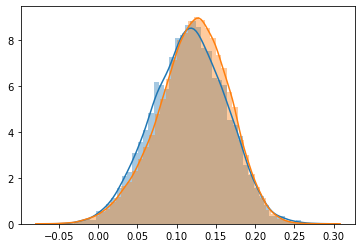

In [42]:
import seaborn as sns
sns.distplot(zero_vals)
sns.distplot(nonzero_vals)

In [48]:
np.mean(zero_vals)
np.mean(nonzero_vals)

0.12055423246639663

In [43]:
df_results = pd.DataFrame({'split_val':layer1_list,
                           'gene_group':layer2_list,
                           'p_val':pval_list,
                            'count_nonzero':count_nonzero_list,
                            'count_zero': count_zero_list,
                            'mean_nonzero': mean_nonzero_list,
                            'mean_zero': mean_zero_list,
                            'std_nonzero':std_nonzero_list,
                            'std_zero':std_zero_list})

In [44]:
df_results.to_csv('data/signature_p_values.csv',index = False)

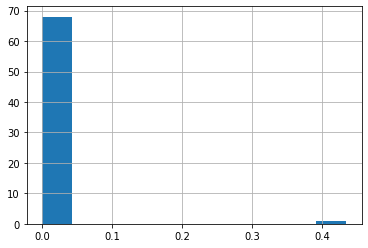

In [45]:
import matplotlib.pyplot as plt
df_results['p_val'].hist()

In [46]:
df_results

,split_val,gene_group,p_val,count_nonzero,count_zero,mean_nonzero,mean_zero,std_nonzero,std_zero
0,GABRP,neuron,0.000000e+00,12570,31247,0.118794,0.100328,0.028086,0.031469
1,GABRP,positive,0.000000e+00,12570,31247,0.106195,0.088294,0.033792,0.037519
2,GABRP,positive_projection,0.000000e+00,12570,31247,0.136043,0.114324,0.040735,0.045426
3,SLC6A12,neuron,4.286603e-13,200,43617,0.123531,0.105543,0.032639,0.031631
4,SLC6A12,positive,3.370517e-08,200,43617,0.108820,0.093358,0.037883,0.037359
5,SLC6A12,positive_projection,2.164989e-09,200,43617,0.140907,0.120461,0.045896,0.045187
6,GAD1,neuron,2.044365e-115,2106,41711,0.120581,0.104870,0.028982,0.031601
7,GAD1,positive,2.844706e-110,2106,41711,0.110902,0.092547,0.034770,0.037286
8,GAD1,positive_projection,5.305765e-128,2106,41711,0.143462,0.119398,0.041872,0.045066
9,GABRE,neuron,0.000000e+00,8780,35037,0.119245,0.102212,0.028353,0.031525
